In [1]:
import numpy as np
import os
import cv2
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             precision_score, recall_score, f1_score, roc_curve, roc_auc_score)
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt

In [ ]:
# Paths for preprocessed data
PREPROCESSED_TRAIN_DIR = "../data/preprocessed_data/traffic/trainNew"
PREPROCESSED_TEST_DIR = "../data/preprocessed_data/traffic/testNew"

image_size = (100, 100)

# Load preprocessed training data
print("Loading preprocessed training data...")
X_train = []
Y_train = []

for class_name in os.listdir(PREPROCESSED_TRAIN_DIR):
    class_dir = os.path.join(PREPROCESSED_TRAIN_DIR, class_name)
    label = int(class_name)  
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Images are already grayscale due to preprocessing
        if img is not None:
            X_train.append(img.flatten()) 
            Y_train.append(label)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
print(f"Loaded {X_train.shape[0]} training images.")


Loading preprocessed training data...
Loaded 6000 training images.


In [ ]:
# Load preprocessed test data
print("Loading preprocessed test data...")
X_test = []
Y_test = []

for img_name in os.listdir(PREPROCESSED_TEST_DIR):
    img_path = os.path.join(PREPROCESSED_TEST_DIR, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
    if img is not None:
        X_test.append(img.flatten())  
        label = int(img_name.split('_')[1])  # Extract digits after 'preprocessed_' for class label
        Y_test.append(label)

X_test = np.array(X_test)
Y_test = np.array(Y_test)
print(f"Loaded {X_test.shape[0]} test images.")

Loading preprocessed test data...
Loaded 1896 test images.


In [ ]:
# Basic decision tree
print("\nTraining Basic Decision Tree Classifier...")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, Y_train)

# Evaluating the basic decision tree
print("\nEvaluating Decision Tree Classifier...")
Y_pred = dt_model.predict(X_test)

accuracy_dt = accuracy_score(Y_test, Y_pred)
report_dt = classification_report(Y_test, Y_pred)

print(f"\nAccuracy: {accuracy_dt:.4f}")
print("\nClassification Report:")
print(report_dt)

# 5-Fold Cross-Validation
print("\nPerforming 5-Fold Cross-Validation...")
cv_scores_dt = cross_val_score(dt_model, X_train, Y_train, cv=5, scoring="accuracy")

print("\nCross-Validation Accuracy Scores:", cv_scores_dt)
print(f"Mean Accuracy: {cv_scores_dt.mean():.4f}")
print(f"Standard Deviation: {cv_scores_dt.std():.4f}")


Training Basic Decision Tree Classifier...

Evaluating Decision Tree Classifier...

Accuracy: 0.1762

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.03      0.17      0.05        12
           2       0.14      0.13      0.14        60
           3       0.15      0.05      0.07        84
           4       0.20      0.17      0.19        58
           5       0.12      0.08      0.10        50
           6       0.08      0.13      0.10        30
           7       0.12      0.08      0.10        50
          10       0.39      0.50      0.44        60
          11       0.77      0.42      0.54       130
          12       0.42      0.91      0.57        22
          13       0.09      0.09      0.09        92
          14       0.00      0.00      0.00        12
          15       0.00      0.00      0.00        36
          16       0.68      0.45      0.54        76
         

In [ ]:
# Confusion matrix and performance metrics
print("\nConfusion Matrix:")
con_matrix = confusion_matrix(Y_test, Y_pred)
print(con_matrix)

precision = precision_score(Y_test, Y_pred, average='weighted', zero_division=0)
recall = recall_score(Y_test, Y_pred, average='weighted')
f1 = f1_score(Y_test, Y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Confusion Matrix:
[[ 0  2  0 ...  0  0  0]
 [ 0  2  0 ...  0  0  0]
 [ 4  4  8 ...  0  2  2]
 ...
 [ 4  2  2 ... 30  2 12]
 [ 0  0  2 ...  4 18  0]
 [ 4  2  2 ...  0  0  2]]
Precision: 0.2793
Recall: 0.1762
F1 Score: 0.1923


In [ ]:
# Hyperparameter tuning with GridSearchCV
print("\nPerforming Grid Search for Hyperparameter Tuning...")
param_grid = {
    'max_depth': [5, 50],  
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)
grid_search.fit(X_train, Y_train)


Performing Grid Search for Hyperparameter Tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 50],
                         'min_samples_leaf': [1, 5],
                         'min_samples_split': [2, 5]},
             scoring='accuracy', verbose=1)

Originally, our parameter grid was:
max_depth: 4 values [5, 50, 70, None]
min_samples_split: 3 values [2, 5, 10]
min_samples_leaf: 3 values [1, 5, 10]
criterion: 2 values ['gini', 'entropy']
Total: 4 * 3 * 3 * 2 = 72 combinations
Total fits: 72 combinations * 5 folds = 360 fits

The best model remained unchanged when using both the original and reduced parameter grids. Based on our initial findings, the optimal parameters were: max_depth of 50, criterion set to 'entropy', min_samples_leaf as 1, and min_samples_split as 2. To improve efficiency and reduce extensive training time, we opted to narrow the parameter grid by limiting the range of max_depth and other parameters.


Best Parameters from Grid Search: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.5211666666666666
Test Accuracy of Best Model: 0.2247

Visualizing the Best Decision Tree...


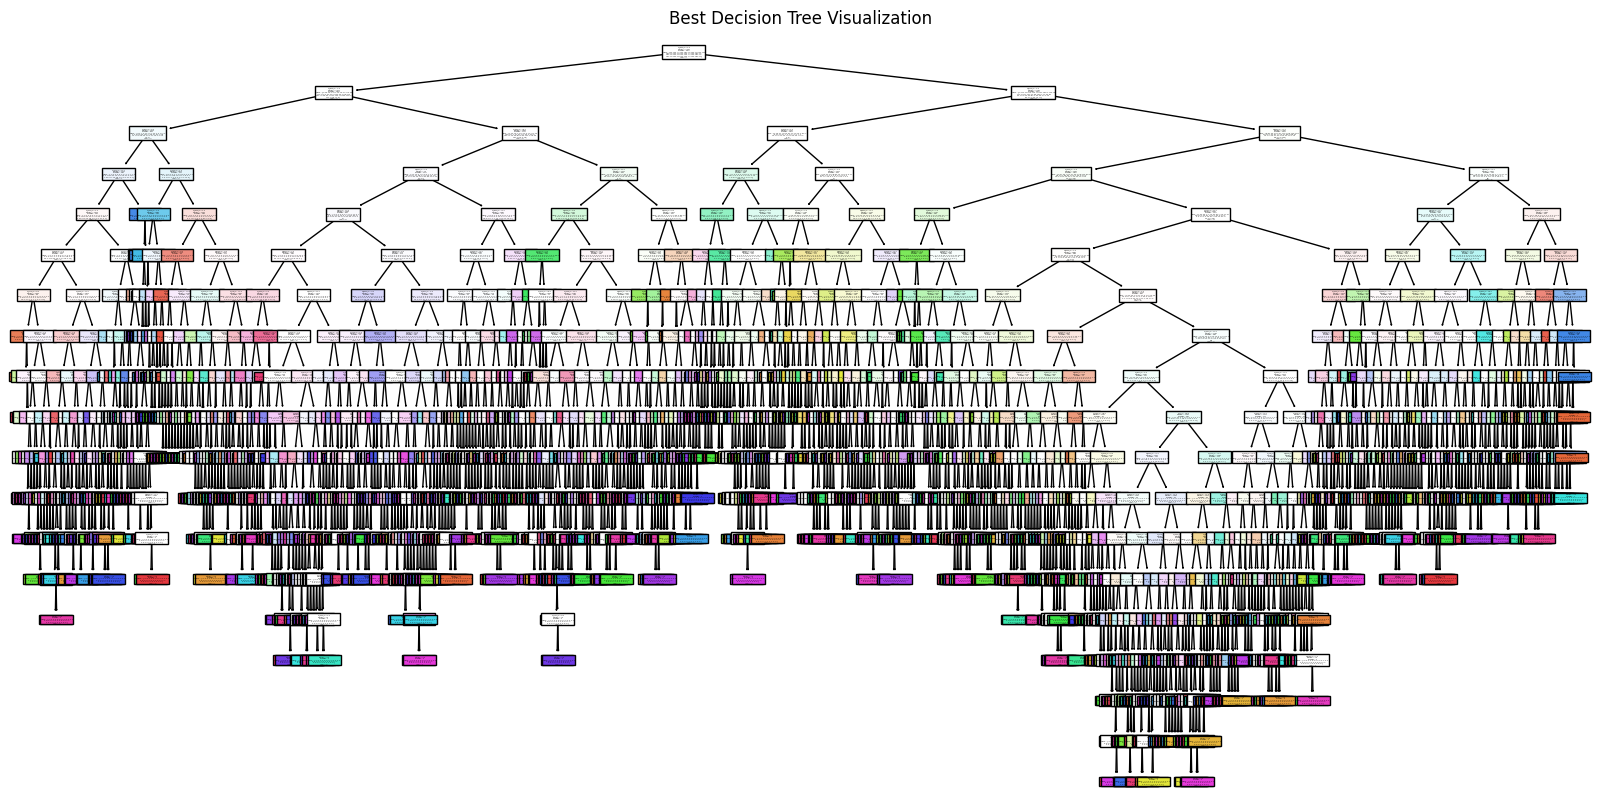

In [ ]:
# Evaluating best model
print("\nBest Parameters from Grid Search:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_
Y_pred_best = best_model.predict(X_test)

accuracy_best = accuracy_score(Y_test, Y_pred_best)
print(f"Test Accuracy of Best Model: {accuracy_best:.4f}")

# Visualizing best decision tree
print("\nVisualizing the Best Decision Tree...")
plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, feature_names=None, class_names=[str(i) for i in range(len(np.unique(Y_train)))])
plt.title("Best Decision Tree Visualization")
plt.show()